# VAD(Voice Activity Detection)

## 1. 데이터 로드

In [5]:
import os
import librosa
import torch
from torch import nn
import torchaudio
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy.signal import wiener
from skimage.metrics import structural_similarity as ssim
from torchaudio.transforms import Spectrogram
from pystoi.stoi import stoi
from torchaudio.transforms import Vad
from scipy.signal import wiener
from scipy.io.wavfile import write
import IPython.display as ipd
from IPython.display import Audio, display
import soundfile as sf

In [ ]:
import os
import librosa

# 파일이 있는 폴더 경로
mix_path = "/data/cjchun/ejkim/enhancement(25.1)/mix"
clean_path = "/data/cjchun/ejkim/enhancement(25.1)/clean"


# 모든 .wav 파일 경로 가져오기
wav_files = [f for f in os.listdir(mix_path) if f.endswith('.wav')]

# 모든 WAV 파일 로드하기
waveforms = []
sample_rates = []

for wav_file in wav_files:
    file_path = os.path.join(mix_path, wav_file)
    try:
        # librosa로 오디오 파일 로드
        waveform, sample_rate = librosa.load(file_path, sr=None)
        waveforms.append(waveform)
        sample_rates.append(sample_rate)
    except Exception as e:
        # 예외가 발생하면 오류 메시지 출력
        print(f"파일 로드 오류: {file_path}, 오류: {e}")

# 확인
print(f"전체 로드된 파일 수: {len(waveforms)}")

# 모든 .wav 파일 경로 가져오기
wav_files = [f for f in os.listdir(clean_path) if f.endswith('.wav')]

# 모든 WAV 파일 로드하기
waveforms = []
sample_rates = []

for wav_file in wav_files:
    file_path = os.path.join(clean_path, wav_file)
    try:
        # librosa로 오디오 파일 로드
        waveform, sample_rate = librosa.load(file_path, sr=None)
        waveforms.append(waveform)
        sample_rates.append(sample_rate)
    except Exception as e:
        # 예외가 발생하면 오류 메시지 출력
        print(f"파일 로드 오류: {file_path}, 오류: {e}")

# 확인
print(f"전체 로드된 파일 수: {len(waveforms)}")


## 2. 데이터 확인

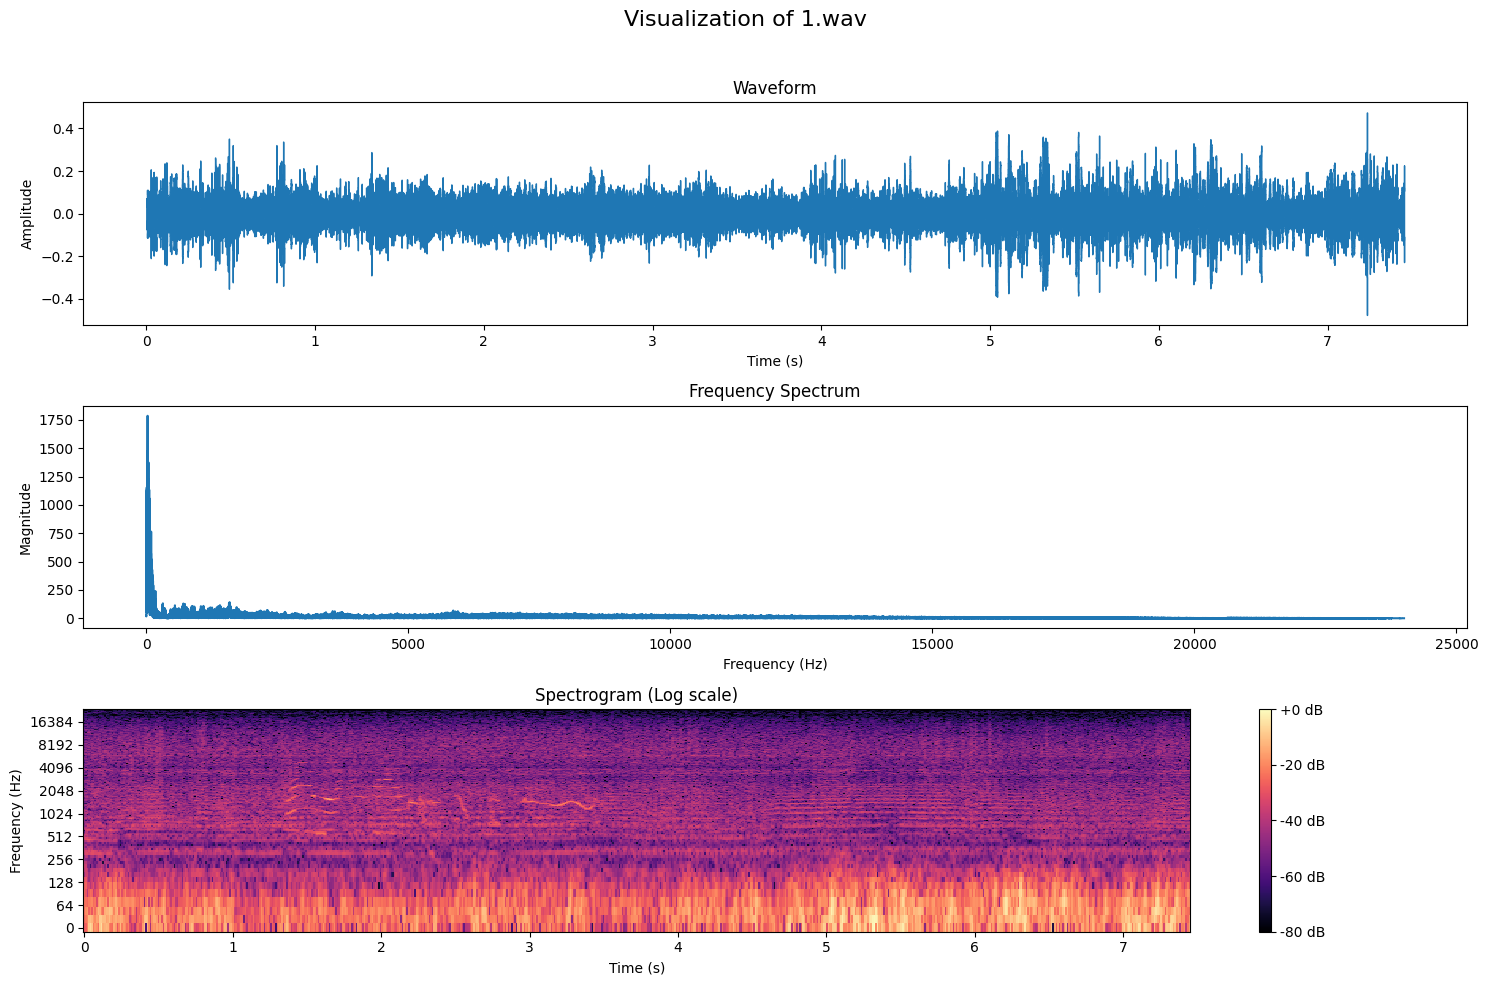

Playing audio:


In [47]:
def visualize_audio_and_play(waveform, sample_rate, title="Audio Visualization"):
    # 시각화 크기 설정
    plt.figure(figsize=(15, 10))

    # 1. Waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(waveform, sr=sample_rate)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # 2. Frequency Spectrum
    plt.subplot(3, 1, 2)
    fft = np.fft.fft(waveform)  # Fast Fourier Transform
    magnitude = np.abs(fft)     # Magnitude
    frequency = np.linspace(0, sample_rate, len(magnitude))
    plt.plot(frequency[:len(magnitude)//2], magnitude[:len(magnitude)//2])
    plt.title("Frequency Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")

    # 3. Spectrogram
    plt.subplot(3, 1, 3)
    S = librosa.stft(waveform)  # Short-time Fourier Transform
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)  # Convert to decibel
    librosa.display.specshow(S_db, sr=sample_rate, x_axis="time", y_axis="log")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Spectrogram (Log scale)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")

    # 전체 제목 및 시각화
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # 오디오 출력
    print("Playing audio:")
    display(Audio(waveform, rate=sample_rate))

# 예제 파일 로드 및 시각화
file_path = "/data/cjchun/ejkim/enhancement(25.1)/mix/13.wav"
waveform, sample_rate = librosa.load(file_path, sr=None)

visualize_audio_and_play(waveform, sample_rate, title="Visualization of 1.wav")


## 데이터 전처리

Audio loaded. Sample rate: 16000, Waveform shape: (119258,)
Applied Winner filter for noise reduction.
Removed NaN or infinite values from the filtered waveform.
Computed STFT. Shape: (513, 466)
Applied IDR mask to the spectrogram.
Reconstructed waveform from masked STFT.


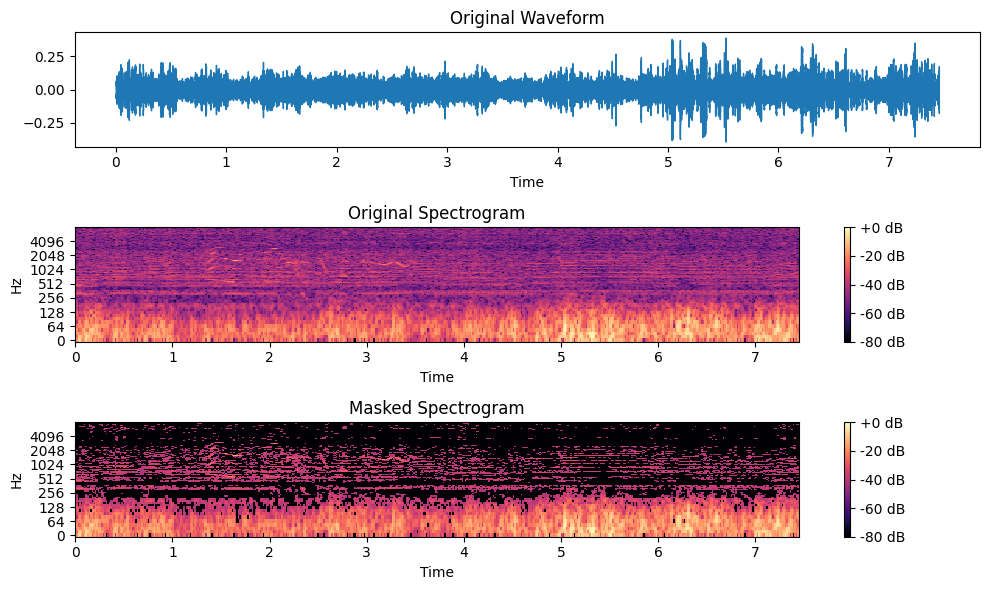

In [48]:
# 데이터 전처리
class AudioDataset(Dataset):
    def __init__(self, mix_dir, clean_dir, mix_files=None, clean_files=None, target_sr=16000, target_length=16000):
        self.mix_dir = mix_dir
        self.clean_dir = clean_dir
        self.target_sr = target_sr
        self.target_length = target_length
        # 파일 리스트 로드
        # mix_dir에서 263개만 사용
        self.mix_files = sorted(os.listdir(mix_dir))[:263] if mix_files is None else mix_files

        # clean_files는 clean_dir에서 263개만 사용
        self.clean_files = sorted(os.listdir(clean_dir))[:263] if clean_files is None else clean_files

        # 두 디렉토리 내 파일 수가 동일한지 확인
        assert len(self.mix_files) == len(self.clean_files), \
            f"Mismatch between mix and clean files. {len(self.mix_files)} vs {len(self.clean_files)}"

    def __len__(self):
        return len(self.mix_files)

    def __getitem__(self, idx):
        # mix와 clean 오디오 파일 로드
        mix_file = os.path.join(self.mix_dir, self.mix_files[idx])
        clean_file = os.path.join(self.clean_dir, self.clean_files[idx])
        
        mix_waveform, sample_rate = torchaudio.load(mix_file)
        clean_waveform, _ = torchaudio.load(clean_file)
        
        # 리샘플링
        if sample_rate != self.target_sr:
            mix_waveform = torchaudio.functional.resample(mix_waveform, sample_rate, self.target_sr)
            clean_waveform = torchaudio.functional.resample(clean_waveform, sample_rate, self.target_sr)

        # 패딩 처리
        if mix_waveform.size(1) > self.target_length:
            mix_waveform = mix_waveform[:, :self.target_length]
            clean_waveform = clean_waveform[:, :self.target_length]
        elif mix_waveform.size(1) < self.target_length:
            padding_length = self.target_length - mix_waveform.size(1)
            mix_waveform = F.pad(mix_waveform, (0, padding_length))
            clean_waveform = F.pad(clean_waveform, (0, padding_length))
        
        return mix_waveform, clean_waveform, sample_rate


In [ ]:
def compute_stft(waveform, n_fft=1024, hop_length=256, win_length=1024):
    # waveform은 3D 텐서로 [batch_size, channels, samples]
    stfts = []
    for batch_idx in range(waveform.size(0)):
        for channel_idx in range(waveform.size(1)):
            # 각 배치 및 채널에 대해 STFT 계산
            stft = torch.stft(waveform[batch_idx, channel_idx, :], n_fft=n_fft, hop_length=hop_length, win_length=win_length, return_complex=True)
            magnitude = torch.abs(stft)  # 복소수의 크기만 추출
            stfts.append(magnitude)
    
    # 3D 텐서로 합치기 (배치 차원, 채널 차원, 시간 차원)
    stfts = torch.stack(stfts, dim=0)
    return stfts


In [ ]:
import torch.nn.functional as F

class UNet1D(nn.Module):
    def __init__(self):
        super(UNet1D, self).__init__()
        
        self.enc1 = self._make_conv_block(513, 16)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.enc2 = self._make_conv_block(16, 32)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.enc3 = self._make_conv_block(32, 64)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bridge = self._make_conv_block(64, 128)
        self.upconv3 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._make_conv_block(128, 64)
        self.upconv2 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2)
        self.dec2 = self._make_conv_block(64, 32)
        self.upconv1 = nn.ConvTranspose1d(32, 16, kernel_size=2, stride=2)
        self.dec1 = self._make_conv_block(32, 16)
        self.outc = nn.Conv1d(16, 1, kernel_size=1)

    def _make_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        bridge = self.bridge(self.pool3(enc3))
        up3 = self.upconv3(bridge)

        # up3의 크기를 enc3와 맞추기 위해 interpolate 사용
        up3 = F.interpolate(up3, size=enc3.size()[2:], mode='linear', align_corners=False)
        dec3 = self.dec3(torch.cat([up3, enc3], dim=1))

        up2 = self.upconv2(dec3)
        # up2의 크기를 enc2와 맞추기 위해 interpolate 사용
        up2 = F.interpolate(up2, size=enc2.size()[2:], mode='linear', align_corners=False)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))

        up1 = self.upconv1(dec2)
        # up1의 크기를 enc1과 맞추기 위해 interpolate 사용
        up1 = F.interpolate(up1, size=enc1.size()[2:], mode='linear', align_corners=False)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))
        
        return self.outc(dec1)


In [ ]:
def estimate_mask(stft_magnitude):
    irm_mask = torch.sigmoid(stft_magnitude)  # IRM
    ibm_mask = (stft_magnitude > 0.5).float()  # IBM
    return irm_mask, ibm_mask


In [ ]:
from torch.optim import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'사용 중인 장치: {device}')

num_epochs = 30
lr = 0.001

model = UNet1D().to(device)
criterion = nn.L1Loss()
optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
model

In [ ]:
def apply_wiener_filter(mix_stft, mask):
    return mix_stft * mask
def compute_mse(predicted, target):
    return F.mse_loss(predicted, target)

In [ ]:
import pystoi
from skimage.metrics import structural_similarity as ssim

def evaluate_stoi(predicted, target, sr=16000):
    # detach()를 사용하여 텐서의 그래디언트 추적을 끈 후 numpy로 변환
    predicted_audio = predicted.squeeze().detach().cpu().numpy()
    target_audio = target.squeeze().detach().cpu().numpy()
    return pystoi.stoi(target_audio, predicted_audio, sr)

def evaluate_ssim(predicted, target):
    predicted_audio = predicted.squeeze().detach().cpu().numpy()
    target_audio = target.squeeze().detach().cpu().numpy()
    return ssim(target_audio, predicted_audio)



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet1D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# mix_dir에서 263개 파일만 사용하여 데이터셋 생성
train_dataset = AudioDataset(mix_dir=mix_path, clean_dir=clean_path)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
# 손실 값을 기록할 리스트
train_losses = []

for epoch in range(30):
    model.train()
    epoch_loss = 0.0
    for mix_waveform, clean_waveform, sample_rate in train_loader:
        mix_waveform = mix_waveform.to(device)
        clean_waveform = clean_waveform.to(device)

        optimizer.zero_grad()
        
        # STFT 변환
        mix_magnitude = compute_stft(mix_waveform)
        clean_magnitude = compute_stft(clean_waveform)

        # 모델에 입력
        predicted_magnitude = model(mix_magnitude)

        # 마스크 추정
        irm_mask, ibm_mask = estimate_mask(predicted_magnitude)

        # 위너 필터 적용
        enhanced_signal = apply_wiener_filter(mix_magnitude, irm_mask)

        # 손실 계산
        loss = compute_mse(enhanced_signal, clean_magnitude)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)  # 에폭별 손실 기록
    print(f"Epoch {epoch+1}/30, Loss: {avg_epoch_loss:.4f}")

In [ ]:
# 평가
model.eval()
for mix_waveform, clean_waveform, sample_rate in train_loader:
    mix_waveform = mix_waveform.to(device)
    clean_waveform = clean_waveform.to(device)

    mix_magnitude = compute_stft(mix_waveform)
    clean_magnitude = compute_stft(clean_waveform)

    # 모델에 입력
    predicted_magnitude = model(mix_magnitude)

    # 마스크 추정
    irm_mask, ibm_mask = estimate_mask(predicted_magnitude)

    # 위너 필터 적용
    enhanced_signal = apply_wiener_filter(mix_magnitude, irm_mask)

    # MSE 계산
    loss = compute_mse(enhanced_signal, clean_magnitude)
    print(f"MSE: {loss.item()}")

    # STOI, SSIM 측정
    stoi_score = evaluate_stoi(enhanced_signal, clean_waveform)
    ssim_score = evaluate_ssim(enhanced_signal, clean_waveform)
    print(f"STOI: {stoi_score:.4f}, SSIM: {ssim_score:.4f}")
    
    break  # 첫 번째 배치만 테스트 (배치 크기 설정에 따라 반복 가능)

# 손실 그래프 출력
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), train_losses, label="Train Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()
